In [1]:
%tensorflow_version 2.x
#!nvidia-smi -L

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
!pip install --quiet ml_collections

In [3]:
import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFont 
import base64
import zipfile
import json
#import requests
import random
import numpy as np
import matplotlib.pylab as pl
import glob
from concurrent.futures import ThreadPoolExecutor
from string import Template

import tensorflow as tf

from IPython.display import Image, HTML, clear_output, Javascript

from ml_collections import ConfigDict

### Config

In [4]:
cfg = ConfigDict()
cfg.logdir = "/tmp/ca" # base log dir
cfg.experiment_name = "0" # directory under log_dir to place output.
cfg.ffmpeg_path = "ffmpeg"

try:
  __IPYTHON__
  cfg.is_ipython = True
except NameError:
  cfg.is_ipython = False

cfg.texture_ca = ConfigDict()
cfg.texture_ca.channel_n = 12
cfg.texture_ca.hidden_n = 96
cfg.texture_ca.fire_rate = 0.5
cfg.texture_ca.batch_size = 4
cfg.texture_ca.lr = 2e-3
cfg.texture_ca.pool_size = 1024
cfg.texture_ca.fixed_seed = 123 # 0 to disable
cfg.texture_ca.lr = 2e-3
cfg.texture_ca.lr_decay = 2000
cfg.texture_ca.rollout_len_min = 32
cfg.texture_ca.rollout_len_max = 64
cfg.texture_ca.train_steps = 2000
cfg.texture_ca.gradnorm = True
cfg.texture_ca.q = 2.0
cfg.texture_ca.bias = True
cfg.texture_ca.learned_filters = 0
cfg.texture_ca.laplacian = True
cfg.texture_ca.gradient = True
cfg.texture_ca.identity = True

# texture synth / style transfer
cfg.texture_ca.ancestor_npy = ''
cfg.texture_ca.img_size = 128
cfg.texture_ca.vgg_input_img_size = 128
cfg.texture_ca.texture_dir = 'textures'
cfg.texture_ca.ancestor_dir = 'models'
cfg.texture_ca.objective = "style:mondrian.jpg" #{style:mondrian.jpg, inception:mixed4b_pool_reduce_pre_relu:30}
cfg.texture_ca.inception_pb = 'gs://modelzoo/vision/other_models/InceptionV1.pb'
cfg.texture_ca.hidden_viz_group = False # Group the hidden states into RGB when vizualizing
cfg.texture_ca.viz_rollout_len = 1000
cfg.texture_ca.overflow_loss_coef = 1e4 # auxiliary loss to keep generated values in [0,1]
tcfg = cfg.texture_ca

### Util

In [5]:
import numpy as np
from tensorflow.io.gfile import GFile
import io
import base64
import requests
import PIL.Image, PIL.ImageDraw
import subprocess


def imread(url, max_size=None, mode=None):
  if isinstance(url, str):
    if url.startswith(('http:', 'https:')):
      r = requests.get(url)
      f = io.BytesIO(r.content)
    else:
      f = GFile(url, mode='rb')
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img


def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = GFile(f, mode='wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def imshow(a, fmt='jpeg'):
  from IPython.display import Image, display
  display(Image(data=imencode(a, fmt)))

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

class Bunch(dict):
  """Dot-accessible dict."""
  def __init__(self, *args, **kwds):
    super(Bunch, self).__init__(*args, **kwds)
    self.__dict__ = self

### Losses

In [6]:
import tensorflow as tf
import numpy as np

style_layers = ['block%d_conv1'%i for i in range(1, 6)]
content_layer = 'block4_conv2'

class StyleModel:
  def __init__(self, input_texture_path):
    vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
    vgg.trainable = False
    layers = style_layers + [content_layer]
    layers = {name:vgg.get_layer(name).output for name in layers}
    self.model = tf.keras.Model([vgg.input], layers)
    self.style_img = imread(input_texture_path, cfg.texture_ca.vgg_input_img_size)
    self.target_style, _ = self.calc_style_content(self.style_img[None,...])

  def run_model(self, img):
    img = img[..., ::-1]*255.0 - np.float32([103.939, 116.779, 123.68])
    layers = self.model(img)
    style = [layers[name] for name in style_layers]
    return style, layers[content_layer]

  def calc_style_content(self, img):
    style_layers, content = self.run_model(img)
    style = [self.gram_style(a) for a in style_layers]
    return style, content

  @tf.function
  def __call__(self, x):
    gs, content = self.calc_style_content(x)
    sl = tf.reduce_mean(self.style_loss(gs, self.target_style))
    return sl

  @tf.function
  def style_loss(self, a, b):
    return tf.add_n([tf.reduce_mean(tf.square(x-y), [-2, -1]) for x, y in zip(a, b)])

  def gram_style(self, a):
    n, h, w, ch = tf.unstack(tf.shape(a))
    a = tf.sqrt(a+1.0)-1.0
    gram = tf.einsum('bhwc, bhwd -> bcd', a, a)
    return gram / tf.cast(h*w, tf.float32)

class Inception:
  def __init__(self, layer, ch):
    with tf.io.gfile.GFile(cfg.texture_ca.inception_pb, 'rb') as f:
      self.graph_def = tf.compat.v1.GraphDef.FromString(f.read())
    self.layer = layer
    self.ch = ch
    avgpool0_idx = [n.name for n in self.graph_def.node].index('avgpool0')
    del self.graph_def.node[avgpool0_idx:]
    # use pre_relu layers for Concat nodes
    node = {n.name:n for n in self.graph_def.node}[layer]
    self.outputs = [layer+':0']
    if 'Concat' in node.op:
      self.outputs = [inp+'_pre_relu:0' for inp in node.input[1:]]
  
  @tf.function
  def __call__(self, x):
    overflow_loss = tf.reduce_mean(tf.square(tf.clip_by_value(x, 0.0, 1.0)-x))
    imgs = x*255.0-117.0
    outputs = tf.import_graph_def(self.graph_def, {'input':imgs}, self.outputs)
    a = tf.concat(outputs, -1)
    return -tf.reduce_mean(a[...,self.ch]) + overflow_loss*cfg.texture_ca.overflow_loss_coef


### Model

In [7]:
import tensorflow as tf
import numpy as np
import json
import os

def pad_repeat(x, pad):
  x = tf.concat([x[:, -pad:], x, x[:, :pad]], 1)
  x = tf.concat([x[:, :, -pad:], x, x[:, :, :pad]], 2)
  return x

def get_variables(f):
  '''Get all vars involved in computing a function. Userful for'''
  with tf.GradientTape() as g:
    f()
    return g.watched_variables()

def fake_quant(x, min, max):
  y = tf.quantization.fake_quant_with_min_max_vars(x, min=min, max=max)
  return y

def fake_param_quant(w):
  bound = tf.stop_gradient(tf.reduce_max(tf.abs(w)))
  w = fake_quant(w, -bound, bound)
  return w

def to_rgb(x):
  return x[..., :3]/(cfg.texture_ca.q) + 0.5

@tf.function
def perceive(x, angle=0.0, repeat=True):
  chn = tf.shape(x)[-1]
  identify = np.outer([0, 1, 0], [0, 1, 0])
  dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
  dy = dx.T
  laplacian = np.outer([1, 2, 1], [1, 2, 1]) / 8.0
  laplacian[1, 1] -= 2.0
  c, s = tf.cos(angle), tf.sin(angle)
  kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy, laplacian], -1)[:, :, None, :]
  kernel = tf.repeat(kernel, chn, 2)
  pad_mode = 'SAME'
  if repeat:
    x = pad_repeat(x, 1)
    pad_mode = 'VALID'
  y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], pad_mode)
  return y

class DenseLayer:
  def __init__(self, in_n, out_n,
              init_fn=tf.initializers.glorot_uniform()):
    w0 = tf.concat([init_fn([in_n, out_n]), tf.zeros([1, out_n])], 0)
    self.w = tf.Variable(w0)

  def embody(self):
    w = fake_param_quant(self.w)
    w, b = w[:-1], w[-1]
    w = w[None, None, ...]
    def f(x):
      # TFjs matMul doesn't work with non-2d tensors, so using
      # conv2d instead of 'tf.matmul(x, w)+b'
      return tf.nn.conv2d(x, w, 1, 'VALID')+b
    return f

class CAModel:

  def __init__(self, params=None):
    super().__init__()
    self.fire_rate = cfg.texture_ca.fire_rate
    self.channel_n = cfg.texture_ca.channel_n

    init_fn = tf.initializers.glorot_normal(cfg.texture_ca.fixed_seed or None)
    self.layer1 = DenseLayer(self.channel_n*4, cfg.texture_ca.hidden_n, init_fn)
    self.layer2 = DenseLayer(cfg.texture_ca.hidden_n, self.channel_n, tf.zeros)

    self.params = get_variables(self.embody)
    if params is not None:
      self.set_params(params)

  def embody(self, quantized=True):
    layer1 = self.layer1.embody()
    layer2 = self.layer2.embody()

    def noquant(x, min, max):
      return tf.clip_by_value(x, min, max)
    qfunc = fake_quant if quantized else noquant

    @tf.function
    def f(x, fire_rate=None, angle=0.0, step_size=1.0):
      y = perceive(x, angle)
      y = qfunc(y, min=-cfg.texture_ca.q, max=cfg.texture_ca.q)
      y = tf.nn.relu(layer1(y))
      y = qfunc(y, min=0.0, max=cfg.texture_ca.q)
      y = layer2(y)
      dx = y*step_size
      dx = qfunc(dx, min=-cfg.texture_ca.q, max=cfg.texture_ca.q)
      if fire_rate is None:
        fire_rate = self.fire_rate
      update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
      x += dx * tf.cast(update_mask, tf.float32)
      x = qfunc(x, min=-cfg.texture_ca.q, max=cfg.texture_ca.q)
      return x
    return f

  def get_params(self):
    return [p.numpy() for p in self.params]

  def set_params(self, params):
    for v, p in zip(self.params, params):
      v.assign(p)

  def save_params(self, filename):
    with tf.io.gfile.GFile(filename, mode='wb') as f: 
      np.save(f, self.get_params())

  def load_params(self, filename):
    with tf.io.gfile.GFile(filename, mode='rb') as f: 
      params = np.load(f, allow_pickle=True)
      self.set_params(params)

### TextureSynthTrainer

In [8]:
import numpy as np

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

def create_loss_model():
  loss_type, loss_params = tcfg.objective.split(':', 1)
  if loss_type == "style":
    texture_fn = loss_params
    input_texture_path = "%s/%s"%(tcfg.texture_dir, texture_fn)
    loss_model = StyleModel(input_texture_path)
  elif loss_type == "inception":
    layer_name, ch = loss_params.split(':')
    loss_model = Inception(layer_name, int(ch))
  return loss_model

class TextureSynthTrainer:
  def __init__(self, loss_model=None):
    self.experiment_log_dir = "%s/%s"%(cfg.logdir, cfg.experiment_name)
    self.writer = tf.summary.create_file_writer(self.experiment_log_dir)

    if loss_model is None:
      loss_model = create_loss_model()
    self.loss_model = loss_model

    self.ca = CAModel()
    if tcfg.ancestor_npy:
      self.ancestor_ca = CAModel()
      ancestor_fn = "%s/%s" % (tcfg.ancestor_dir, tcfg.ancestor_npy)
      self.ancestor_ca.load_params(ancestor_fn)
      self.ca.load_params(ancestor_fn)
      logging.info("loaded pre-trained model %s" % tcfg.ancestor_npy)
    self.loss_log = []
    self.pool = SamplePool(x=self.seed_fn(tcfg.pool_size))
    lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [1000], [tcfg.lr, tcfg.lr*0.1])
    self.trainer = tf.keras.optimizers.Adam(lr_sched)

  def visualize_batch_tf(self, x0, x, step_num):
    vis0 = np.hstack(to_rgb(x0))
    vis1 = np.hstack(to_rgb(x))
    vis = np.vstack([vis0, vis1])
    tf.summary.image("batch_vis", vis[None, ...])

  def train(self):
    with self.writer.as_default():
      for _ in range(tcfg.train_steps+1):
        step_num = len(self.loss_log)
        step = self.train_step()
        if step_num%50 == 0 or step_num == tcfg.train_steps:
          self.visualize_batch_tf(step.x0, step.batch.x, step_num)
          self.ca.save_params("%s/%s.npy" % (cfg.logdir, cfg.experiment_name))
        logging.info('step: %d, log10(loss): %s, loss: %s'%(len(self.loss_log), np.log10(step.loss), step.loss.numpy()))
      self.save_video("%s/%s.mp4" % (cfg.logdir, cfg.experiment_name), self.ca.embody)

  def train_step(self):
    step_num = len(self.loss_log)
    tf.summary.experimental.set_step(step_num)
    batch = self.pool.sample(tcfg.batch_size)
    x0 = batch.x.copy()
    if step_num%2==0:
      x0[:1] = self.seed_fn(1)
    batch.x[:], loss = self._train_step(x0)
    batch.commit()
    tf.summary.scalar("loss", loss)
    self.loss_log.append(loss.numpy())
    return Bunch(batch=batch, x0=x0, loss=loss, step_num=step_num)

  @tf.function
  def _train_step(self, x):
    iter_n = tf.random.uniform([], tcfg.rollout_len_min, tcfg.rollout_len_max, tf.int32)
    with tf.GradientTape(persistent=False) as g:
      f = self.ca.embody()
      for i in tf.range(iter_n):
        x = f(x)
      loss = self.loss_model(to_rgb(x))
    grads = g.gradient(loss, self.ca.params)
    grads = [g/(tf.norm(g)+1e-8) for g in grads]
    self.trainer.apply_gradients(zip(grads, self.ca.params))
    return x, loss

  def seed_fn(self, n):
    states = np.zeros([n, tcfg.img_size, tcfg.img_size, tcfg.channel_n], np.float32)
    return states

  def save_video(self, path, f):
    state = self.seed_fn(1)
    f = self.ca.embody()
    if tcfg.ancestor_npy:
      state_ancestor = self.seed_fn(1)
      f_ancestor = self.ancestor_ca.embody()
    with VideoWriter(path, 60.0) as vid:
      for i in range(tcfg.viz_rollout_len):
        # visualize the RGB + hidden states.
        if tcfg.hidden_viz_group:
          padding_channel_len = (3 - state[0].shape[2] % 3) % 3
          splitframe = np.split(np.pad(state[0], ((0,0), (0,0), (0,padding_channel_len)), mode='constant'), (state[0].shape[2] + padding_channel_len)/3, 2)
        else:
          hidden = np.transpose(np.repeat(state[0][..., 3:, None], 3, -1), (2, 0, 1, 3))
          splitframe = np.concatenate([state[0][None, ..., :3], hidden], 0)
        frame = to_rgb(tile2d(splitframe))
        vid.add(frame)
        if tcfg.ancestor_npy:
          c_state = f(state, fire_rate=0.5)
          a_state = f_ancestor(state, fire_rate=0.5)
          progress = max(1.25*(i/tcfg.viz_rollout_len) - 0.25, 0.0)
          state = (1-progress)*c_state + progress*a_state
        else:
          state = f(state, fire_rate=0.5)

In [9]:
def export_models_to_js(models, fixed_filter_n=4):
  '''Exoprt numpy models in a form that ca.js can read.'''
  model_names = list(models.keys())
  models_js = {'model_names':model_names, 'layers': []}
  params = models.values()
  quant_scale_zero = [(2.0, 0.0), (4.0, 127.0 / 255.0)]
  for i, layer in enumerate(zip(*params)):
    shape = layer[0].shape
    layer = np.array(layer)  # shape: [n, h, w]
    if i == 0:
      # Replaced with np equiv. for time being so this works internally.
      # layer[:,:-1] = rearrange(layer[:,:-1], 'n (h c) w -> n (c h) w', c=fixed_filter_n)
      s = layer[:, :-1].shape
      layer[:, :-1] = (layer[:, :-1]
                       .reshape(s[0], -1, fixed_filter_n, s[2])
                       .transpose(0, 2, 1, 3)
                       .reshape(s))
    #layer = rearrange(layer, 'n h (w c) -> h (n w) c', c=4)
    # N.B. this 4 is not the fixed filter number, but a webgl implementation detail.
    # Pad when number of channels is not a multiple of 4.
    s = layer.shape
    layer = np.pad(layer, ((0,0), (0,0), (0, (4 - s[2]) % 4)), mode='constant')
    layer = layer.reshape(s[0], s[1], -1, 4)
    n, ht, wt = layer.shape[:3]
    w = 1
    while w<n and w*wt < (n+w-1)//w*ht:
      w += 1
    layer = tile2d(layer, w)
    layout = (w, (n+w-1)//w)

    scale = 2.0*np.abs(layer).max()
    layer = np.round(layer/scale*255.0+127.0)
    layer = np.uint8(layer.clip(0, 255))

    url = im2url(layer, 'png')
    layer_js = {'scale': scale,
                'data': url,
                'shape':shape,
                'quant_scale_zero': quant_scale_zero[i],
                'layout': layout}
    models_js['layers'].append(layer_js)
  return models_js


# texture NCA

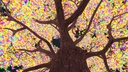

In [10]:
texture_name = 'tenere.jpg'
img_f = io.BytesIO(open(texture_name, 'rb').read())
img = imread(img_f, cfg.texture_ca.vgg_input_img_size, mode='RGB')
clear_output()
imshow(img)
imwrite('_target.png', img)

In [17]:
tf.random.set_seed(42)
loss_model = StyleModel('_target.png')
out_fn = os.path.join(texture_name + '.npy')
trainer = TextureSynthTrainer(loss_model=loss_model)
r = trainer.train_step()
# trainer.ca.save_params(out_fn)

/var/folders/36/tsggdjzx2yb0mmhxy97qf45m0000gn/T/ipykernel_2848/1489709732.py:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)


In [18]:
params = np.load(out_fn, allow_pickle=True)
for i, p in enumerate(trainer.ca.params):
    print(np.all(np.isclose(p,params[i])))

True
True


In [19]:
models = {name:np.load(name, allow_pickle=True) for name in glob.glob('*.npy')}
js_models = export_models_to_js(models)
with open('models.json', 'w+') as f:
    json.dump(js_models, f)